In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from hyperopt import hp, tpe, fmin, Trials
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder



In [12]:
# Load the dataset
df = pd.read_csv('WineQT.csv')

# Separate features and target variable
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Function to preprocess the data
def preprocess_data(X, y):
    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        label_encoders[column] = LabelEncoder()
        X[column] = label_encoders[column].fit_transform(X[column])
    return X, y

# Function to split the data
def split_data(X, y, test_size=0.2, val_size=0.25):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    val_size_adjusted = val_size / (1 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, random_state=42)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



In [13]:
# Preprocess the data
X, y = preprocess_data(X, y)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

# Define the hyperparameter space
hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}

# Define the objective function for regression
def objective_function(hyperparameters):
    global iteration_n
    if iteration_n == 0:
        model = XGBRegressor()
    else:
        hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
        hyperparameters['n_estimators'] = int(hyperparameters['n_estimators'])
        hyperparameters['min_child_weight'] = int(hyperparameters['min_child_weight'])
        model = XGBRegressor(**hyperparameters)
    iteration_n += 1
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = mean_squared_error(y_val, y_predict)
    return score



In [14]:
# Initialize hyperopt trials and iteration counter
trials = Trials()
iteration_n = 0

# Run hyperparameter optimization
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
scores_round = np.array(trials.losses())



100%|██████████| 20/20 [01:15<00:00,  3.80s/trial, best loss: 101940.05092418088]


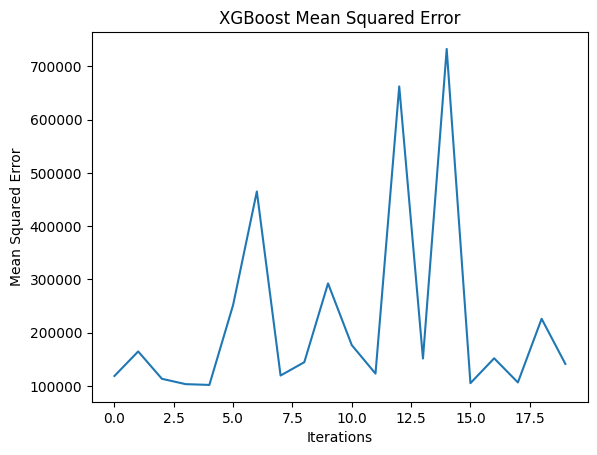

Best Hyperparameters: {'alpha': 2.85295625440457e-07, 'colsample_bylevel': 0.81095114591485, 'colsample_bytree': 0.8568160423021364, 'gamma': 2.0532318633651354e-07, 'lambda': 1.148941148633499, 'learning_rate': 0.0011941274870880475, 'max_depth': 8.0, 'min_child_weight': 1.0, 'n_estimators': 5200.0, 'subsample': 0.7751554496796376}
Best Trial: {'state': 2, 'tid': 4, 'spec': None, 'result': {'loss': 101940.05092418088, 'status': 'ok'}, 'misc': {'tid': 4, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [4], 'colsample_bylevel': [4], 'colsample_bytree': [4], 'gamma': [4], 'lambda': [4], 'learning_rate': [4], 'max_depth': [4], 'min_child_weight': [4], 'n_estimators': [4], 'subsample': [4]}, 'vals': {'alpha': [2.85295625440457e-07], 'colsample_bylevel': [0.81095114591485], 'colsample_bytree': [0.8568160423021364], 'gamma': [2.0532318633651354e-07], 'lambda': [1.148941148633499], 'learning_rate': [0.0011941274870880475], 'max_depth': [8.0], 'min_child_wei

In [15]:
# Save the best hyperparameters
with open('best_wine_xgboost_params_regression.pkl', 'wb') as f:
    pickle.dump(best_hyperparameters, f)

# Plot the mean squared error over iterations
plt.plot(range(20), scores_round)
plt.title('XGBoost Mean Squared Error')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.show()

# Display the best hyperparameters and the best trial
print("Best Hyperparameters:", best_hyperparameters)
print("Best Trial:", trials.best_trial)
